In [1]:
import os
os.listdir("/content")


['.config', 'drive', 'clean_jobs_phase2.csv', 'sample_data']

In [3]:
import pandas as pd

df = pd.read_csv(
    "/content/clean_jobs_phase2.csv",
    engine="python"
)

df.shape


(8261, 21)

In [4]:
import sqlite3

conn = sqlite3.connect("job_market.db")

df.to_sql("jobs_cleaned", conn, if_exists="replace", index=False)

print("Data written to SQLite.")


Data written to SQLite.


In [5]:
pd.read_sql("SELECT COUNT(*) FROM jobs_cleaned;", conn)


,COUNT(*)
0,8261


In [6]:
pd.read_sql("""
SELECT company, COUNT(*) AS postings
FROM jobs_cleaned
GROUP BY company
ORDER BY postings DESC
LIMIT 10;
""", conn)


,company,postings
0,Apple,645
1,CyberCoders,166
2,Microsoft,149
3,Deloitte,106
4,Jobot,101
5,Salesforce,100
6,Google,92
7,Uber,85
8,IBM,84
9,Optello,77


In [7]:
pd.read_sql("""
SELECT location, COUNT(*) AS postings
FROM jobs_cleaned
GROUP BY location
ORDER BY postings DESC
LIMIT 10;
""", conn)


,location,postings
0,United States,527
1,"New York, NY",467
2,"San Francisco, CA",417
3,"Seattle, WA",412
4,"Austin, TX",401
5,"Cupertino, CA",289
6,"Chicago, IL",203
7,"Atlanta, GA",185
8,"Boston, MA",158
9,"Los Angeles, CA",135


In [8]:
pd.read_sql("""
SELECT ROUND(AVG(months_experience), 1) AS avg_months
FROM jobs_cleaned;
""", conn)


,avg_months
0,49.5


In [9]:
pd.read_sql("""
SELECT education, COUNT(*) AS postings
FROM jobs_cleaned
GROUP BY education
ORDER BY postings DESC;
""", conn)


,education,postings
0,bachelor degree,7458
1,unknown,734
2,associate degree,56
3,high school,13


In [10]:
import pandas as pd

# explode skills into rows
skills_df = df[["post_id", "skills"]].explode("skills")

# remove empty
skills_df = skills_df.dropna(subset=["skills"])

skills_df.head()


,post_id,skills
0,2632814552,"['python', 'sql', 'aws', 'spark', 'machine lea..."
1,2632810866,"['python', 'java', 'c++', 'javascript', 'sql',..."
2,2632812746,"['java', 'c#', 'javascript', 'aws', 'azure', '..."
3,2632817427,"['java', 'c#', 'javascript', 'aws', 'azure', '..."
4,2632817426,"['java', 'c#', 'javascript', 'aws', 'azure', '..."


In [11]:
skills_df.to_sql("job_skills", conn, if_exists="replace", index=False)


8261

In [12]:
pd.read_sql("""
SELECT skills, COUNT(*) AS demand
FROM job_skills
GROUP BY skills
ORDER BY demand DESC
LIMIT 20;
""", conn)


,skills,demand
0,[],950
1,['excel'],182
2,['sql'],75
3,"['python', 'java', 'c++']",73
4,"['python', 'java', 'kubernetes', 'excel']",65
5,"['python', 'java', 'c++', 'c#', 'javascript', ...",65
6,['python'],62
7,"['java', 'sql']",60
8,['machine learning'],58
9,"['python', 'c++']",54


In [13]:
df["skills"].head()


,skills
0,"['python', 'sql', 'aws', 'spark', 'machine lea..."
1,"['python', 'java', 'c++', 'javascript', 'sql',..."
2,"['java', 'c#', 'javascript', 'aws', 'azure', '..."
3,"['java', 'c#', 'javascript', 'aws', 'azure', '..."
4,"['java', 'c#', 'javascript', 'aws', 'azure', '..."


In [14]:
# NOTE:
# Initial skill normalization grouped entire lists instead of single skills.
# Rebuilding job_skills table after converting stringified lists into
# Python lists and exploding properly.

import ast

def parse_skill_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df["skills"] = df["skills"].apply(parse_skill_list)


In [15]:
skills_df = df[["post_id", "skills"]].explode("skills")
skills_df = skills_df.dropna(subset=["skills"])

skills_df.head()


,post_id,skills
0,2632814552,python
0,2632814552,sql
0,2632814552,aws
0,2632814552,spark
0,2632814552,machine learning


In [16]:
skills_df.to_sql("job_skills", conn, if_exists="replace", index=False)


37068

In [17]:
pd.read_sql("""
SELECT skills, COUNT(*) AS demand
FROM job_skills
GROUP BY skills
ORDER BY demand DESC
LIMIT 15;
""", conn)


,skills,demand
0,python,4404
1,java,3350
2,sql,2989
3,excel,2844
4,aws,2587
5,machine learning,2523
6,c++,1416
7,javascript,1317
8,kubernetes,1256
9,azure,1187


In [18]:
top_skills_df = pd.read_sql("""
SELECT skills, COUNT(*) AS demand
FROM job_skills
GROUP BY skills
ORDER BY demand DESC
LIMIT 10;
""", conn)

top_skills_df


,skills,demand
0,python,4404
1,java,3350
2,sql,2989
3,excel,2844
4,aws,2587
5,machine learning,2523
6,c++,1416
7,javascript,1317
8,kubernetes,1256
9,azure,1187


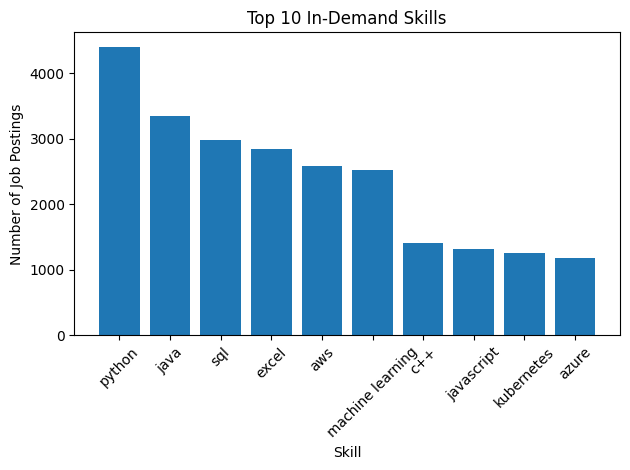

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(top_skills_df["skills"], top_skills_df["demand"])
plt.xticks(rotation=45)
plt.title("Top 10 In-Demand Skills")
plt.xlabel("Skill")
plt.ylabel("Number of Job Postings")
plt.tight_layout()
plt.show()


In [20]:
top_skills_df.to_csv("/content/top_skills.csv", index=False)


In [21]:
top_companies = pd.read_sql("""
SELECT company, COUNT(*) AS postings
FROM jobs_cleaned
GROUP BY company
ORDER BY postings DESC
LIMIT 20;
""", conn)

top_companies.to_csv("/content/top_companies.csv", index=False)


In [22]:
top_locations = pd.read_sql("""
SELECT location, COUNT(*) AS postings
FROM jobs_cleaned
GROUP BY location
ORDER BY postings DESC
LIMIT 20;
""", conn)

top_locations.to_csv("/content/top_locations.csv", index=False)


In [23]:
from google.colab import files

files.download("/content/top_skills.csv")
files.download("/content/top_companies.csv")
files.download("/content/top_locations.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>